# TFG - VIU - Carlos Romero Matarin

# Datos Temporales

In [ ]:
import numpy as np
import rasterio
import os
from glob import glob
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

IMAGENES_DIR = r"C:/Users/crome/Desktop/VIU/Code/Datos/AMB_TEMP/images"
MASCARAS_DIR = r"C:/Users/crome/Desktop/VIU/Code/Datos/AMB_TEMP/masks"
OUT_YOLO_DIR = "C:/Users/crome/Desktop/VIU/Code/Datos/AMB_TEMP/npy_files/"

years = [2020, 2022, 2024]

for year in years:

    folder = "C:/Users/crome/Desktop/VIU/Code/Datos/AMB_"+str(year)+"/"
    tif_files = sorted(glob("C:/Users/crome/Desktop/VIU/Code/Datos/AMB_"+str(year)+"/*.tif"))

    os.makedirs(IMAGENES_DIR, exist_ok=True)
    os.makedirs(MASCARAS_DIR, exist_ok=True)
    os.makedirs(OUT_YOLO_DIR, exist_ok=True)

    # u-net:
    target_rgb_shape = (256, 256, 3)
    target_mask_shape = (256, 256)

    errores = []

    for tif_path in tif_files:
        name = os.path.basename(tif_path).replace('.tif', '')

        try:
            with rasterio.open(tif_path) as src:
                img = src.read()

            rgb = np.stack([img[0], img[1], img[2]], axis=-1).astype(np.float32) / 10000.0
            mask = img[3].astype(np.uint8)

            # Redimensionar
            rgb = resize(rgb, target_rgb_shape, preserve_range=True, anti_aliasing=True)
            mask = resize(mask, target_mask_shape, order=0, preserve_range=True).astype(np.uint8)

            np.save(os.path.join(IMAGENES_DIR, f'{name}_rgb.npy'), rgb)
            np.save(os.path.join(MASCARAS_DIR, f'{name}_mask.npy'), mask)

        except Exception as e:
            print(f"Error procesando {name}: {e}")
            errores.append(name)

    print("Conversión completada.")
    if errores:
        print("Errores en archivos:", errores)

    # Yolo:

    for tif_file in sorted(glob(os.path.join(folder, 'AMB_*.tif'))):
        with rasterio.open(tif_file) as src:
            img = src.read([1, 2, 3])  # B4, B3, B2 (ajustar si es Sentinel)
            img = np.clip(img, 0, 10000) / 10000.0
            img = (img.transpose(1, 2, 0) * 255).astype(np.uint8)

            name = os.path.basename(tif_file).replace('.tif', '.jpg')
            Image.fromarray(img).save(os.path.join(OUT_YOLO_DIR, name))



1/1 [==============================] - 1s 513ms/step

image 1/1 C:\Users\crome\Desktop\VIU\Code\Datos\AMB_TEMP\npy_files\AMB_R7_C5_2020.jpg: 544x640 1 Agricola, 4 Industrias, 3 Poblacions, 145.2ms
Speed: 4.0ms preprocess, 145.2ms inference, 13.8ms postprocess per image at shape (1, 3, 544, 640)
1/1 [==============================] - 0s 120ms/step

image 1/1 C:\Users\crome\Desktop\VIU\Code\Datos\AMB_TEMP\npy_files\AMB_R7_C5_2022.jpg: 544x640 1 Agricola, 4 Industrias, 3 Poblacions, 90.2ms
Speed: 13.4ms preprocess, 90.2ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)
1/1 [==============================] - 0s 125ms/step

image 1/1 C:\Users\crome\Desktop\VIU\Code\Datos\AMB_TEMP\npy_files\AMB_R7_C5_2024.jpg: 544x640 1 Agricola, 3 Industrias, 3 Poblacions, 79.1ms
Speed: 7.8ms preprocess, 79.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


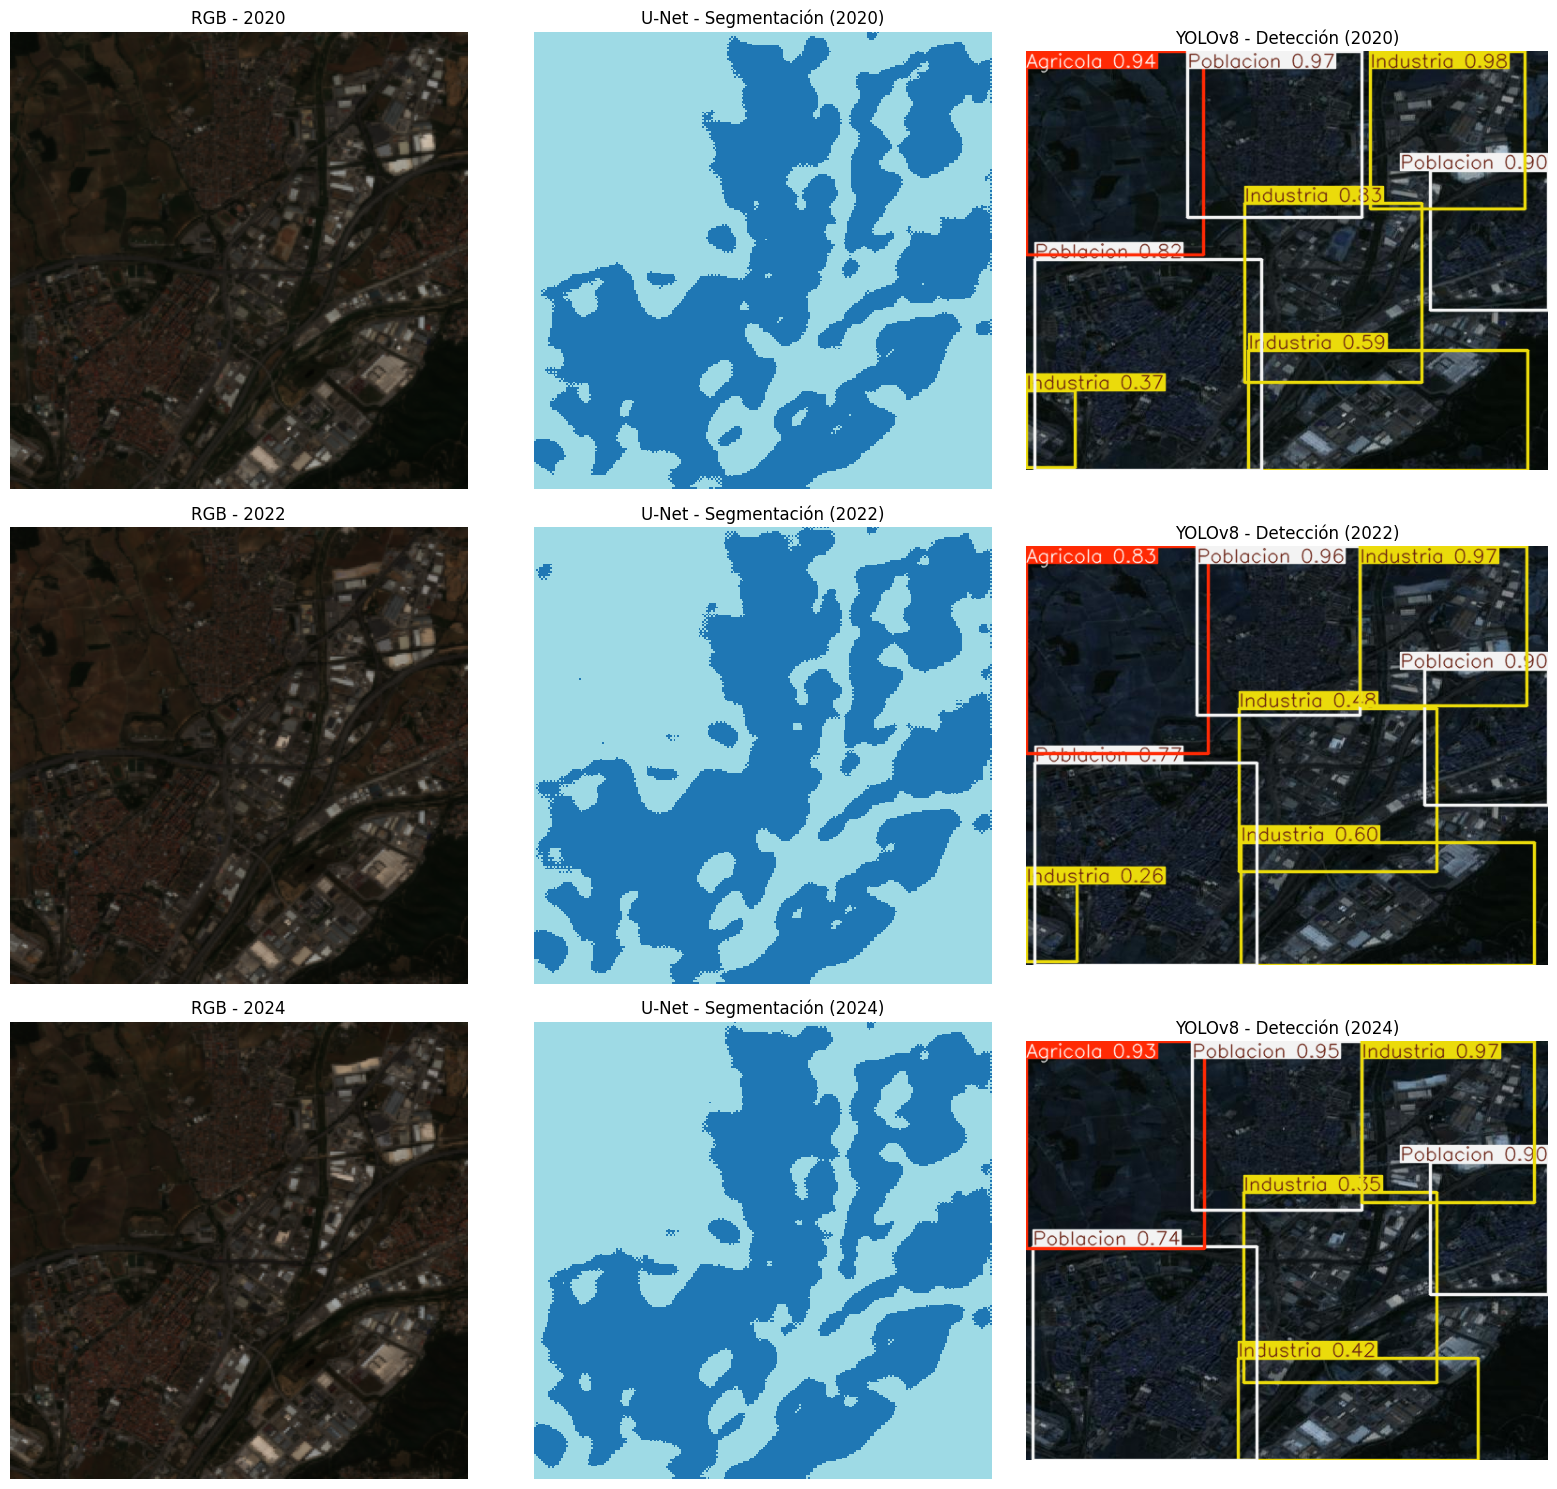

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from ultralytics import YOLO
import os
import cv2
from PIL import Image

# Cargar modelos
model_unet = load_model("mejor_modelo.h5")
modelo_yolo = YOLO(r"C:\Users\crome\Desktop\VIU\Code\runs\detect\yolov8_model9\weights\best.pt")


def predecir_unet(img):
    if img.max() > 1: img = img / 10000.0
    pred = model_unet.predict(np.expand_dims(img, axis=0))[0]
    return np.argmax(pred, axis=-1)

def predecir_yolo(imagen_path):
    resultados = modelo_yolo(imagen_path)
    return resultados[0]


fechas = ["2020", "2022", "2024"]
zona = "R7_C5"

# Ruta de imágenes .npy y .jpg
RGB_NPY_DIR = r"C:/Users/crome/Desktop/VIU/Code/Datos/AMB_TEMP/images"
RGB_JPG_DIR = "C:/Users/crome/Desktop/VIU/Code/Datos/AMB_TEMP/npy_files/"

# Cargar imágenes .npy para U-Net
imagenes_rgb = {
    year: np.load(os.path.join(RGB_NPY_DIR, f"AMB_{zona}_{year}_rgb.npy"))
    for year in fechas
}

# Visualización conjunta
fig, axs = plt.subplots(len(fechas), 3, figsize=(16, 5 * len(fechas)))

for i, year in enumerate(fechas):
    # 1. Imagen RGB
    rgb = imagenes_rgb[year]

    # 2. Predicción U-Net
    pred_mask = predecir_unet(rgb)

    # 3. Predicción YOLO
    imagen_jpg_path = os.path.join(RGB_JPG_DIR, f"AMB_{zona}_{year}.jpg")
    pred_yolo = predecir_yolo(imagen_jpg_path)

    # Mostrar
    axs[i, 0].imshow(rgb)
    axs[i, 0].set_title(f"RGB - {year}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(pred_mask, cmap='tab20', interpolation='none')
    axs[i, 1].set_title(f"U-Net - Segmentación ({year})")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(pred_yolo.plot())
    axs[i, 2].set_title(f"YOLOv8 - Detección ({year})")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()



In [2]:
def comparar_segmentacion(mask1, mask2):
    cambio = mask1 != mask2
    total = cambio.size
    n_cambiado = np.sum(cambio)
    porcentaje_cambiado = 100 * n_cambiado / total
    return n_cambiado, porcentaje_cambiado

# Comparaciones entre años
cambios_unet = {}
for y1, y2 in [("2020", "2022"), ("2022", "2024"), ("2020", "2024")]:
    m1 = predecir_unet(imagenes_rgb[y1])
    m2 = predecir_unet(imagenes_rgb[y2])
    n, p = comparar_segmentacion(m1, m2)
    cambios_unet[f"{y1}-{y2}"] = {"px_cambiados": n, "porcentaje": round(p, 2)}

# Mostrar resultados
print("Cambios en segmentación (U-Net):")
for k, v in cambios_unet.items():
    print(f"- {k}: {v['px_cambiados']} píxeles cambiados ({v['porcentaje']}%)")


from collections import Counter

# Inicializar diccionario
conteo_yolo = {}

for year in fechas:
    jpg_path = os.path.join(RGB_JPG_DIR, f"AMB_{zona}_{year}.jpg")
    resultado = predecir_yolo(jpg_path)

    clases = resultado.names
    ids_detectados = [int(cls) for cls in resultado.boxes.cls.cpu().numpy()]
    conteo = Counter(ids_detectados)

    # Guardamos con nombre de clase
    conteo_yolo[year] = {clases[k]: v for k, v in conteo.items()}

# Mostrar
print("Conteo YOLO por clase:")
for year in conteo_yolo:
    print(f"\n🗓 Año {year}:")
    for clase, count in conteo_yolo[year].items():
        print(f"- {clase}: {count} detecciones")



1/1 [==============================] - 0s 127ms/step
Cambios en segmentación (U-Net):
- 2020-2022: 3016 píxeles cambiados (4.6%)
- 2022-2024: 2872 píxeles cambiados (4.38%)
- 2020-2024: 3284 píxeles cambiados (5.01%)

image 1/1 C:\Users\crome\Desktop\VIU\Code\Datos\AMB_TEMP\npy_files\AMB_R7_C5_2020.jpg: 544x640 1 Agricola, 4 Industrias, 3 Poblacions, 86.7ms
Speed: 1.2ms preprocess, 86.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 C:\Users\crome\Desktop\VIU\Code\Datos\AMB_TEMP\npy_files\AMB_R7_C5_2022.jpg: 544x640 1 Agricola, 4 Industrias, 3 Poblacions, 78.0ms
Speed: 5.0ms preprocess, 78.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 C:\Users\crome\Desktop\VIU\Code\Datos\AMB_TEMP\npy_files\AMB_R7_C5_2024.jpg: 544x640 1 Agricola, 3 Industrias, 3 Poblacions, 88.4ms
Speed: 1.7ms preprocess, 88.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)
Conteo YOLO por clase:

🗓 Año 2020:
- Industria: 4 detecciones


In [3]:
import matplotlib.pyplot as plt

def calcular_ict(unet_cambios, yolo_conteos, clases_objetivo=["Población", "Industria", "Agrícola"]):
    comparaciones = list(unet_cambios.keys())
    indice_compuesto = {}

    for comp in comparaciones:
        y1, y2 = comp.split("-")
        
        cambio_pct = unet_cambios[comp]["porcentaje"]
        cambio_norm = cambio_pct / 100
        
        yolo_y1 = sum(yolo_conteos[y1].get(cl, 0) for cl in clases_objetivo)
        yolo_y2 = sum(yolo_conteos[y2].get(cl, 0) for cl in clases_objetivo)
        yolo_diff = abs(yolo_y2 - yolo_y1)
        yolo_total = max(yolo_y1, yolo_y2, 1)
        yolo_norm = yolo_diff / yolo_total

        ictt = round((cambio_norm + yolo_norm) / 2, 3)

        indice_compuesto[comp] = {
            "cambio_pct": cambio_pct,
            "yolo_diff": yolo_diff,
            "cambio_norm": cambio_norm,
            "yolo_norm": yolo_norm,
            "ICTT": ictt
        }

    return indice_compuesto

# Uso:
ictt_resultado = calcular_ict(cambios_unet, conteo_yolo)

# Mostrar
print("\nÍndice Compuesto de Transformación Territorial (ICTT):")
for comp, v in ictt_resultado.items():
    print(f"- {comp}: {v['ICTT']} (U-Net: {v['cambio_pct']}%, YOLO Δ: {v['yolo_diff']})")



Índice Compuesto de Transformación Territorial (ICTT):
- 2020-2022: 0.023 (U-Net: 4.6%, YOLO Δ: 0)
- 2022-2024: 0.147 (U-Net: 4.38%, YOLO Δ: 1)
- 2020-2024: 0.15 (U-Net: 5.01%, YOLO Δ: 1)


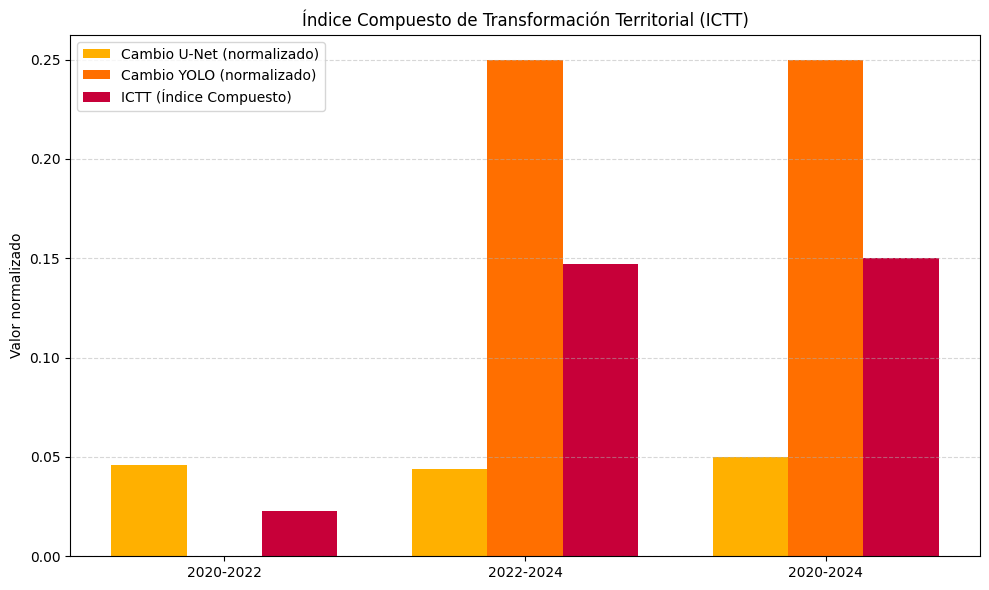

In [7]:
# Visualizar como gráfico
comparaciones = list(ictt_resultado.keys())
unet_values = [ictt_resultado[c]["cambio_norm"] for c in comparaciones]
yolo_values = [ictt_resultado[c]["yolo_norm"] for c in comparaciones]
ictt_values = [ictt_resultado[c]["ICTT"] for c in comparaciones]

x = range(len(comparaciones))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar([i - width for i in x], unet_values, width=width, label="Cambio U-Net (normalizado)", color="#FFB000")
plt.bar(x, yolo_values, width=width, label="Cambio YOLO (normalizado)", color="#FF6F00")
plt.bar([i + width for i in x], ictt_values, width=width, label="ICTT (Índice Compuesto)", color="#C70039")

plt.xticks(x, comparaciones)
plt.ylabel("Valor normalizado")
plt.title("Índice Compuesto de Transformación Territorial (ICTT)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()